#  Teeth Classification Project

## 1. Understanding the Problem

The goal of this project is to build a reliable computer vision model that can classify dental images into **seven distinct categories**. This classification task is part of a broader AI solution aimed at enhancing diagnostic accuracy and patient care in the dental healthcare industry.

We aim to:
- Preprocess and prepare dental images for training and evaluation.
- Visualize class distributions to check for balance in the dataset.
- Apply effective image augmentation techniques to improve model performance.
- Develop and train a custom deep learning model using **TensorFlow or PyTorch**.
- Establish a performance baseline for future improvements.

###  Dataset Overview

The dataset is organized into three main directories:
- **Training/**: Contains subfolders for each class (e.g., CaS, CoS, Gum, etc.), with labeled images used for model training.
- **Validation/**: Contains similarly structured class folders for validation purposes during training.
- **Other folders** (e.g., output, outputs, out): Appear to contain result images or temporary files that will be handled during model development or result generation.

Each class folder (e.g., `CaS`, `CoS`, `MC`, `Gum`, etc.) represents a specific dental condition or structure.

---

This understanding sets the foundation for our next steps in preprocessing, visualization, and model training.


## 2. Loading the Dataset from Google Drive

Since our dataset is stored on Google Drive, we will begin by mounting the drive and navigating to the dataset directory. This allows us to access the training and validation images directly from Drive during the development process.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 3. Preparing and Preprocessing the Data

To train a computer vision model, we must first convert all the image files into numerical arrays. This allows the model to understand and learn patterns from the pixel data.

Here are the main steps for this process:
- Load and resize each image to a fixed size (e.g., 224x224).
- Convert image data into NumPy arrays.
- Normalize pixel values to the range [0, 1] for better training performance.
- Assign a label (as a number) to each image based on its folder name.
- Split the data into training and validation sets.


In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

from tqdm import tqdm

## Load Training and Validation Data

In [3]:

def load_images_to_numpy(root_path, target_size=(224, 224), normalize=True, max_images=None):
    """
    Reads all images from class-subfolders in root_path and returns NumPy arrays.

    Parameters:
    - root_path: str, main folder (e.g., 'dataset/train')
    - target_size: tuple, image resize dimensions like (224, 224)
    - normalize: bool, if True divides pixels by 255
    - max_images: int, optional limit for total images (for testing)

    Returns:
    - X: np.ndarray of shape (n_samples, height, width, 3)
    - y: np.ndarray of shape (n_samples,)
    - label_map: dict mapping class names to integer labels
    """

    X, y = [], []
    label_names = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    label_map = {name: idx for idx, name in enumerate(label_names)}

    total = 0
    for class_name in label_names:
        class_dir = os.path.join(root_path, class_name)
        for file in tqdm(os.listdir(class_dir), desc=f"Processing '{class_name}'"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, file)
                try:
                    img = Image.open(img_path).convert("RGB").resize(target_size)
                    img_array = np.array(img, dtype=np.float32)
                    if normalize:
                        img_array /= 255.0
                    X.append(img_array)
                    y.append(label_map[class_name])
                    total += 1
                    if max_images and total >= max_images:
                        break
                except Exception as e:
                    print(f" Skipped image: {img_path} due to error: {e}")
        if max_images and total >= max_images:
            break

    return np.array(X), np.array(y), label_map


In [4]:
X_train, y_train, label_map = load_images_to_numpy("/content/drive/MyDrive/datasets/Teeth_Dataset/Training")
X_val, y_val, _ = load_images_to_numpy("/content/drive/MyDrive/datasets/Teeth_Dataset/Validation")
X_test, y_test, _ = load_images_to_numpy("/content/drive/MyDrive/datasets/Teeth_Dataset/Testing")


Processing 'OT': 100%|██████████| 131/131 [00:04<00:00, 31.44it/s]


In [5]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("label_map:", label_map)


X_train: (3087, 224, 224, 3)
y_train: (3087,)
label_map: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [6]:
X_train[0][1].shape

(224, 3)

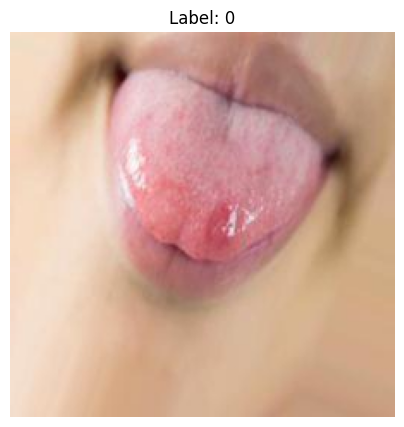

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[20], cmap='gray')
plt.title(f"Label: {y_train[5]}")
plt.axis('off')
plt.show()


## 4. Visual Inspection of the Dataset

We will display one or two random images from each class in both the **Training** and **Validation** sets.


In [8]:
import random

def show_samples(images, labels, samples_per_class=2, title='Dataset Samples'):
    unique_classes = np.unique(labels)
    plt.figure(figsize=(samples_per_class * 2, len(unique_classes) * 2))
    shown = 0

    for class_name in unique_classes:
        class_indices = np.where(labels == class_name)[0]
        chosen = random.sample(list(class_indices), min(samples_per_class, len(class_indices)))
        for idx in chosen:
            plt.subplot(len(unique_classes), samples_per_class, shown + 1)
            plt.imshow(images[idx] ,cmap='gray')
            plt.title(class_name)
            plt.axis('off')
            shown += 1

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


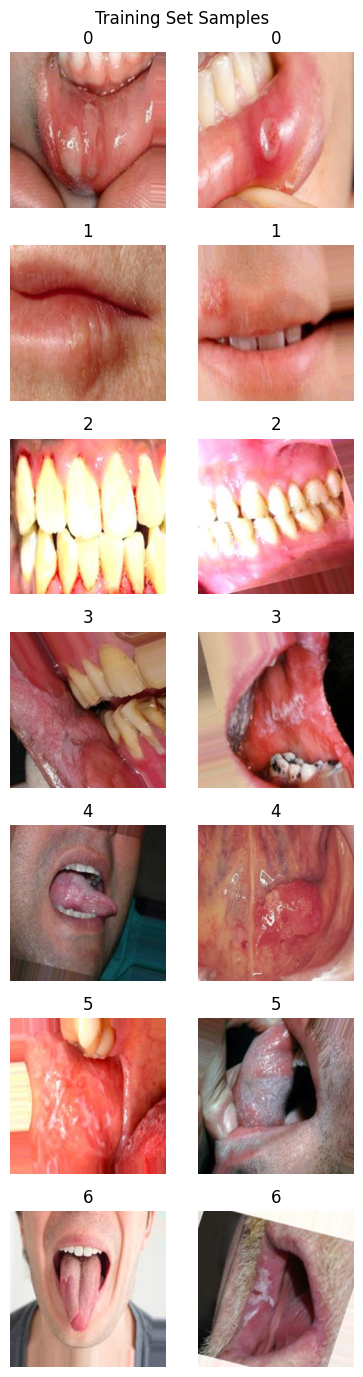

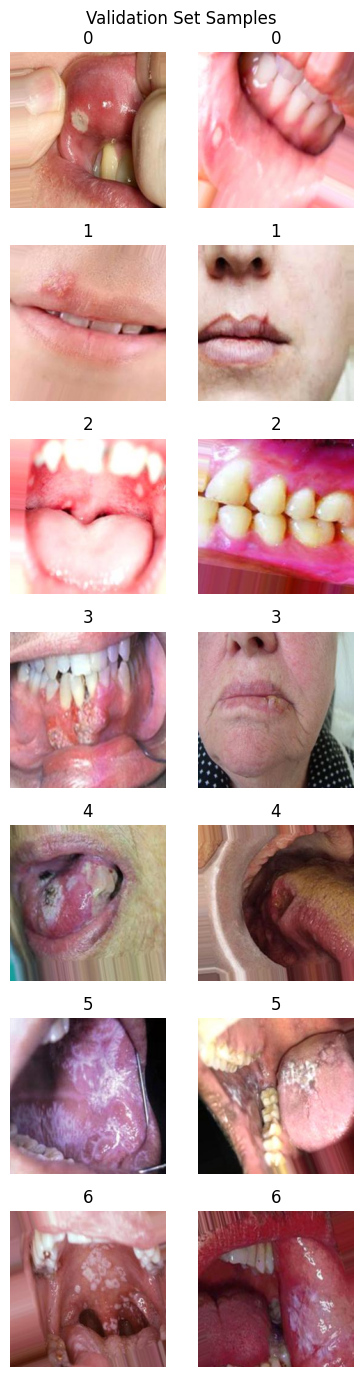

In [9]:

show_samples(X_train, y_train, samples_per_class=2, title='Training Set Samples')


show_samples(X_val, y_val, samples_per_class=2, title='Validation Set Samples')


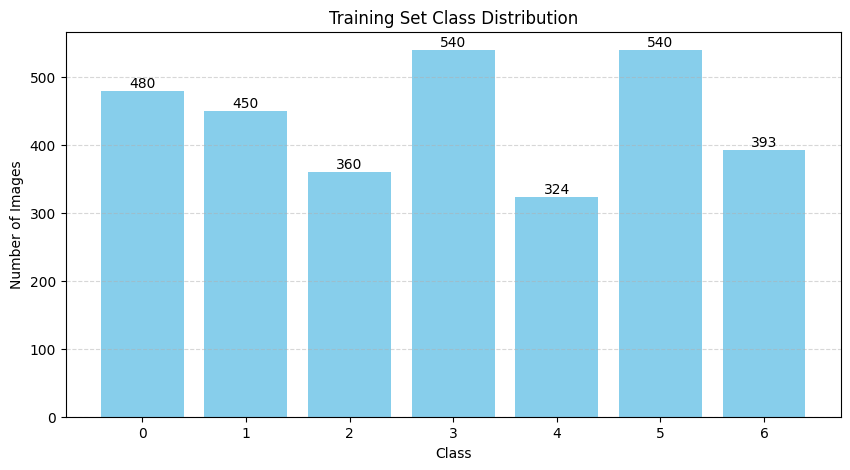

In [10]:
from collections import Counter

def plot_class_distribution(labels, title):
    counter = Counter(labels)
    classes = list(counter.keys())
    counts = list(counter.values())

    plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")

    # Add counts on top
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5, f'{int(height)}', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# Visualize training set
plot_class_distribution(y_train, "Training Set Class Distribution")



## Building the Model

We will now define a simple **fully connected neural network** using TensorFlow's `Sequential` API. This architecture is useful for baseline testing and understanding how dense layers behave with flattened image inputs.

###  Model Structure:

- **Input:** 224x224 RGB images.
- **Flatten Layer:** Converts the image into a 1D vector.
- **Dense Layer (128 units):** Learns abstract features using ReLU activation.
- **Dense Layer (64 units):** Further feature extraction with ReLU.
- **Output Layer (Softmax):** 7 output units with softmax for classification.

> Note: The number of output units should match the number of classes in our dataset (in our case, `7` classes). We'll update this in the final version.


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (3087, 224, 224, 3)
X_test: (1028, 224, 224, 3)


In [12]:
#flatten
X_train_f =X_train.reshape(-1, 224 * 224 * 3)
X_val_f = X_val.reshape(-1, 224 * 224 * 3)
X_test_f= X_test.reshape(-1, 224 * 224 * 3)

In [13]:
print("X_train:", X_train_f.shape)
print("X_test:", X_test_f.shape)

X_train: (3087, 150528)
X_test: (1028, 150528)


In [14]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu',input_shape=(150528,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,276,423 (73.53 MB)

 Trainable params: 19,276,423 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Compiling the Model

Before training, we need to compile the model. This step defines how the model will learn by specifying:

- **Optimizer:** Controls how the model updates weights — we use `'adam'`, which is fast and widely used.
- **Loss Function:** Measures how far the predictions are from the true labels.
  - Since we are using **Label Encoding** (integer labels like 0, 1, 2...), we use `'sparse_categorical_crossentropy'`.
- **Metrics:** We will track the **accuracy** during training and validation.

Now we compile the model using these configurations.


In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 9. Training the Model

We are now ready to train the model using the training dataset

In [19]:
# Train the model
history = model.fit(
    X_train_f, y_train,
    validation_data=(X_val_f, y_val),
    epochs=20,batch_size=32

)


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1743 - loss: 27.1341 - val_accuracy: 0.1946 - val_loss: 6.9234
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2291 - loss: 4.1851 - val_accuracy: 0.1780 - val_loss: 4.9503
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2343 - loss: 3.3642 - val_accuracy: 0.1537 - val_loss: 3.7344
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2932 - loss: 2.6156 - val_accuracy: 0.2442 - val_loss: 2.3814
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2661 - loss: 2.5257 - val_accuracy: 0.2481 - val_loss: 2.2611
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2907 - loss: 2.2144 - val_accuracy: 0.1975 - val_loss: 2.6003
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2830 - loss: 2.1041 - val_accuracy: 0.2179 - val_loss: 2.1718
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3288 - loss: 1.8594 - val_accuracy: 0.1926 - 

In [20]:
import pandas as pd
history_df = pd.DataFrame(history.history)

<Axes: >

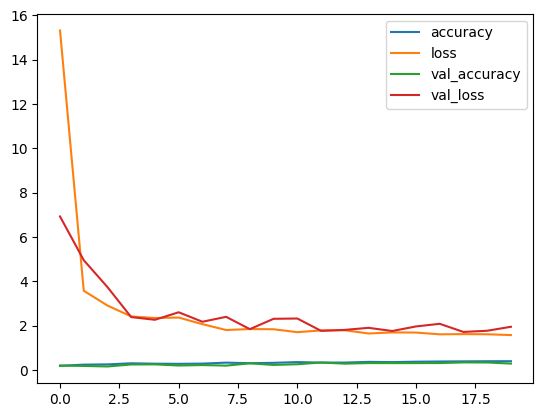

In [21]:
history_df.plot()

In [22]:
# model evalation
model.evaluate(X_test_f, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4151 - loss: 1.5944


[1.950537919998169, 0.29474708437919617]


## Improving Baseline Model with CNN

### Baseline Model Recap
In our initial attempt, we used a simple neural network that consisted only of fully connected (dense) layers after flattening the image input:


In [23]:
from tensorflow.keras import layers, models
model_2 = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=30
)


Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.1890 - loss: 2.1655 - val_accuracy: 0.3142 - val_loss: 1.7692
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3090 - loss: 1.7432 - val_accuracy: 0.4018 - val_loss: 1.5801
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.3592 - loss: 1.6052 - val_accuracy: 0.4377 - val_loss: 1.4809
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.4605 - loss: 1.3860 - val_accuracy: 0.5136 - val_loss: 1.2856
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5730 - loss: 1.1548 - val_accuracy: 0.5603 - val_loss: 1.1996
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6026 - loss: 1.0195 - val_accuracy: 0.5700 - val_loss: 1.1867
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.6944 - loss: 0.8275 - val_accuracy: 0.5710 - val_loss: 1.1876
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7265 - loss: 0.7340 - v

In [26]:
history_df = pd.DataFrame(history.history)

<Axes: >

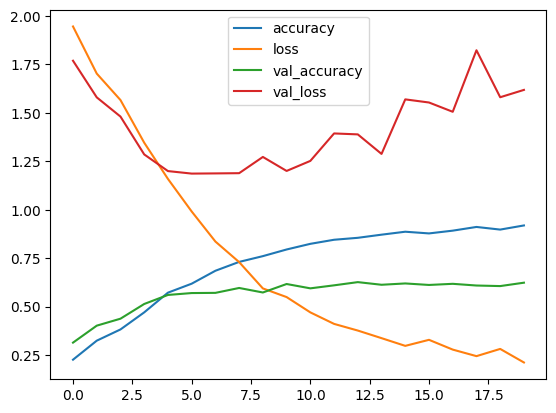

In [27]:
history_df.plot()

In [28]:
y_pred = model_2.predict(X_test)
y_pred

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


array([[2.30217818e-02, 9.68913376e-01, 7.68648321e-03, ...,
        3.08374802e-05, 1.68609782e-04, 3.04522946e-05],
       [2.63807416e-01, 1.38129026e-01, 6.02974469e-05, ...,
        5.17727528e-03, 1.09455896e-05, 1.70675106e-04],
       [9.20933247e-01, 6.93889484e-02, 3.80332436e-04, ...,
        2.10757862e-04, 1.22217869e-04, 1.74288556e-03],
       ...,
       [1.94220860e-02, 1.17329378e-02, 1.63381044e-02, ...,
        4.02046174e-01, 1.05709985e-01, 3.92101169e-01],
       [3.60490203e-01, 3.99926466e-06, 4.24009115e-01, ...,
        3.54564041e-02, 1.03703268e-01, 7.62700289e-02],
       [2.50503188e-03, 6.35024435e-06, 1.10061066e-02, ...,
        1.16869742e-02, 3.51245135e-01, 6.09387815e-01]], dtype=float32)

In [29]:
loss,accuracy =model_2.evaluate(X_test,y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6836 - loss: 1.3060
Test Accuracy: 0.6245
Test Loss: 1.6563


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [31]:
# Train the model
history_SE = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=30,
    callbacks=[early_stop]
)


Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9098 - loss: 0.2363 - val_accuracy: 0.5973 - val_loss: 1.7803
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9176 - loss: 0.2182 - val_accuracy: 0.6333 - val_loss: 1.5793
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9223 - loss: 0.2011 - val_accuracy: 0.6119 - val_loss: 1.7743
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9261 - loss: 0.1867 - val_accuracy: 0.6304 - val_loss: 1.8102
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9222 - loss: 0.1904 - val_accuracy: 0.6187 - val_loss: 1.9031
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9436 - loss: 0.1387 - val_accuracy: 0.6265 - val_loss: 1.8281
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9390 - loss: 0.1446 - val_accuracy: 0.6206 - val_loss: 1.9145


In [32]:
oss,accuracy =model_2.evaluate(X_test,y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6910 - loss: 1.2805
Test Accuracy: 0.6342
Test Loss: 1.6563


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)
history = model_2.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=40)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 415ms/step - accuracy: 0.3919 - loss: 1.7766 - val_accuracy: 0.5837 - val_loss: 1.2166
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.4909 - loss: 1.3655 - val_accuracy: 0.6304 - val_loss: 1.0802
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 377ms/step - accuracy: 0.5399 - loss: 1.2663 - val_accuracy: 0.6304 - val_loss: 0.9889
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 388ms/step - accuracy: 0.5466 - loss: 1.2629 - val_accuracy: 0.6702 - val_loss: 0.9697
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 386ms/step - accuracy: 0.5487 - loss: 1.2529 - val_accuracy: 0.6887 - val_loss: 0.9135
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 389ms/step - accuracy: 0.5623 - loss: 1.1371 - val_accuracy: 0.7111 - val_loss: 0.8234
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 387ms/step - accuracy: 0.5750 - loss: 1.1500 - val_accuracy: 0.7218 - val_loss: 0.8277
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 380ms/step - accuracy: 0.6015 - loss: 1.0641 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 399ms/step - accuracy: 0.6885 - loss: 0.8712 - val_accuracy: 0.8016 - val_loss: 0.5610
Epoch 17/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 383ms/step - accuracy: 0.6708 - loss: 0.8809 - val_accuracy: 0.8385 - val_loss: 0.5203
Epoch 18/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 380ms/step - accuracy: 0.6927 - loss: 0.8276 - val_accuracy: 0.8278 - val_loss: 0.5181
Epoch 19/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 398ms/step - accuracy: 0.6986 - loss: 0.8218 - val_accuracy: 0.7870 - val_loss: 0.5973
Epoch 20/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 392ms/step - accuracy: 0.6996 - loss: 0.7998 - val_accuracy: 0.8152 - val_loss: 0.5029
Epoch 21/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 383ms/step - accuracy: 0.7143 - loss: 0.8085 - val_accuracy: 0.8414 - val_loss: 0.5006
Epoch 22/40
81/97 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7151 - loss: 0.7447

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 370ms/step - accuracy: 0.7179 - loss: 0.7421 - val_accuracy: 0.8502 - val_loss: 0.4671
Epoch 23/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 402ms/step - accuracy: 0.7322 - loss: 0.7721 - val_accuracy: 0.8346 - val_loss: 0.4641
Epoch 24/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.7379 - loss: 0.7199 - val_accuracy: 0.8424 - val_loss: 0.4639
Epoch 25/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.7400 - loss: 0.6971 - val_accuracy: 0.8677 - val_loss: 0.3855
Epoch 26/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.7511 - loss: 0.6793 - val_accuracy: 0.8327 - val_loss: 0.4960
Epoch 27/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.7454 - loss: 0.7524 - val_accuracy: 0.8609 - val_loss: 0.4132
Epoch 28/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 403ms/step - accuracy: 0.7457 - loss: 0.6817 - val_accuracy: 0.8473 - val_loss: 0.4448
Epoch 29/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.7469 - loss: 0.6894 - val_accuracy

In [34]:
history_df = pd.DataFrame(history.history)

<Axes: >

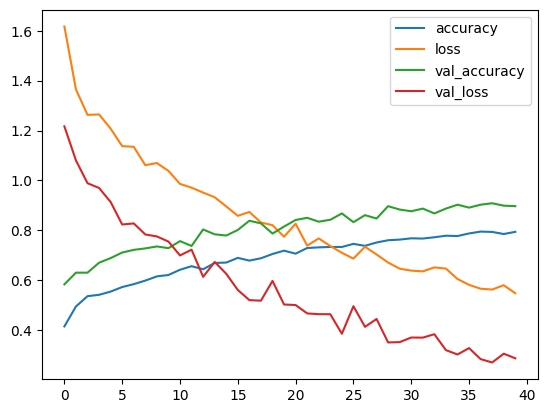

In [35]:
history_df.plot()

# Final Evaluation

In [36]:
loss,accuracy =model_2.evaluate(X_test,y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9162 - loss: 0.2528
Test Accuracy: 0.9173
Test Loss: 0.2577


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


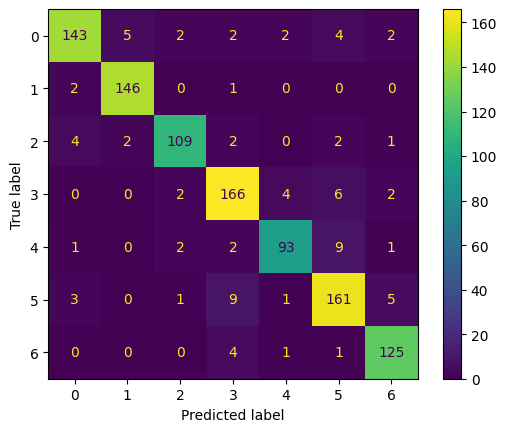

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model_2.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_labels, target_names=label_map.keys()))


              precision    recall  f1-score   support

         CaS       0.93      0.89      0.91       160
         CoS       0.95      0.98      0.97       149
         Gum       0.94      0.91      0.92       120
          MC       0.89      0.92      0.91       180
          OC       0.92      0.86      0.89       108
         OLP       0.88      0.89      0.89       180
          OT       0.92      0.95      0.94       131

    accuracy                           0.92      1028
   macro avg       0.92      0.92      0.92      1028
weighted avg       0.92      0.92      0.92      1028



# Save Your Trained Model

In [39]:
model_2.save("my_model.h5")

In [ ]:
model_2.save('../saved_models/my_model.h5')
